### К алгоритму kNN, реализованному на уроке, реализуйте добавление весов соседей по любому из показанных на уроке принципов.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]    

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

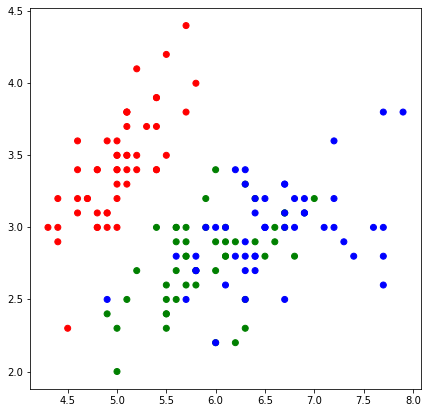

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.show()

In [5]:
# Для взвешивания соседей в зависимости от номера исспользуем 1/i

In [6]:
# Евклидова метрика 
def e_metrics(x1, x2):  
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [7]:
# Алгоритм KNN
def knn(x_train, y_train, x_test, k):

    answers = []

    for x in x_test:
        test_distances = []
           
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
            
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        i = 1
        for d in sorted(test_distances)[0:k]: 
            classes[d[1]] += 1/i
            i += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [8]:
# точность
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [9]:
# Визуализация
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

Точность алгоритма при k = 7 и w = 1/i: 0.733


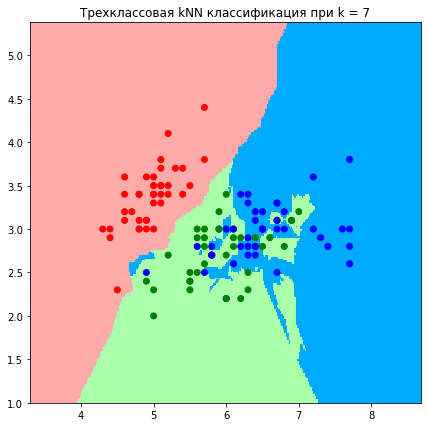

In [19]:
y_pred = knn(X_train, y_train, X_test, 7)
print(f'Точность алгоритма при k = 7 и w = 1/i: {accuracy(y_pred, y_test):.3f}')
get_graph(X_train, y_train, 7)

### Напишите функцию по подсчёту метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и постройте график её зависимости от k (взять от 1 до 10) для выборки данных из этого урока.

In [10]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

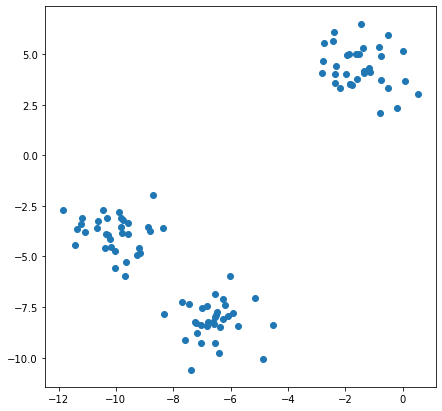

In [11]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [12]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [13]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [49]:
def e_metrics_clusters(cluster, centroid):  
    distance = 0
    for i in range(len(cluster)):
        for j in range(len(cluster[i])):
            distance += np.square(cluster[i][j] - centroid[i])
        
    return np.sqrt(distance)[1] - np.sqrt(distance)[0]

In [50]:
def n_clusters_find(X, max_iterations = 5, min_distance = 1e-4):
    metrics = []
    for k in range(10):
        centroids, clusters = kmeans(X, k+1, max_iterations, min_distance)
        metrics.append(e_metrics_clusters(clusters, centroids))
        
    plt.figure(figsize=(15, 10))
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Quality of clustering')
    plt.plot(metrics)   
    plt.show()   

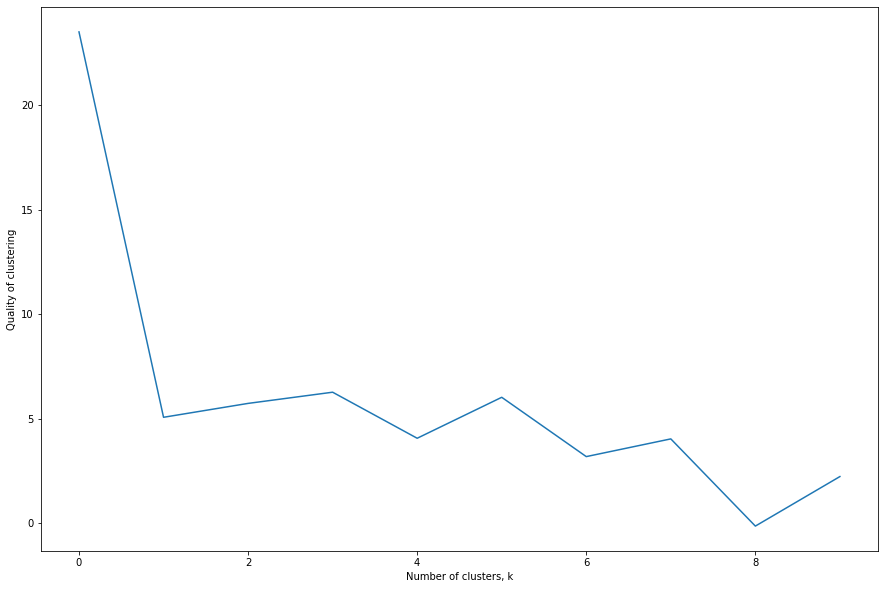

In [51]:
n_clusters_find(X, max_iterations = 10, min_distance = 1e-4)